In [1]:
from pathlib import Path
import torch
import numpy as np
from dataset import WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_sim import Config, TSTransformer
import metrics

In [2]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(452)
np.random.seed(55)
system_seed = 66 # Controls the system generation
data_seed = 0 # Controls the input generation

In [3]:
# Overall settings
out_dir_name = "active_430_400skip_decoder"

# System settings
nu = 1
ny = 1
batch_size = 2048
fixed_system = False # Are we testing on a fixed system?

# Compute settings
no_cuda = False
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  =  "cpu"
device = torch.device(device_name)
device_type = 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [4]:
# Create out dir
out_dir = Path(out_dir_name)
#SEED1
exp_data = torch.load(out_dir / "resume_top32_over80_fixed_err0.01_800k.pt", map_location=device)
exp_data2 = torch.load(out_dir / "resume_rand32_over80_fixed_err0.01_800k.pt", map_location=device)

#SEED2
# exp_data = torch.load(out_dir / "resume_top32_over80_fixed_err0.01_800k_seed2.pt", map_location=device)
# exp_data2 = torch.load(out_dir / "resume_rand32_over80_fixed_err0.01_800k_seed2.pt", map_location=device)

#SEED3
# exp_data = torch.load(out_dir / "resume_top32_over80_fixed_err0.01_800k_seed3.pt", map_location=device)
# exp_data2 = torch.load(out_dir / "resume_rand32_over80_fixed_err0.01_800k_seed3.pt", map_location=device)

#SEED4
# exp_data = torch.load(out_dir / "resume_top32_over80_fixed_err0.01_800k_seed4.pt", map_location=device)
# exp_data2 = torch.load(out_dir / "resume_rand32_over80_fixed_err0.01_800k_seed4.pt", map_location=device)

cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None

cfg2 = exp_data2["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg2.seed
except AttributeError:
    cfg2.seed = None

In [5]:
model_args = exp_data["model_args"]
conf = Config(**model_args)
model = TSTransformer(conf).to(device)
# model = TSTransformer_paper(conf).to(device)/
model.load_state_dict(exp_data["model"]);
# cfg.seed +=1

1


In [6]:
model_args2 = exp_data2["model_args"]
conf2 = Config(**model_args2)
model2 = TSTransformer(conf2).to(device)
# model = TSTransformer_paper(conf).to(device)/
model2.load_state_dict(exp_data2["model"]);
# cfg.seed +=1

1


In [7]:
# Create data loader
lin_opts = dict(mag_range=cfg.mag_range, phase_range=cfg.phase_range, strictly_proper=True)
test_ds = WHDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, 
                                        seq_len=cfg.seq_len_ctx+cfg.seq_len_skip+cfg.seq_len_n_in+cfg.seq_len_new,
                        system_seed=cfg.seed, input_seed=cfg.seed+1, noise_seed=cfg.seed+2,
                        **lin_opts)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=1)

In [8]:
batch_y, batch_u= next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_y_mean = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])
    batch_y_std = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])
    for i in range(len(batch_y_ctx[0,0,:])):
        print(batch_y_ctx[:,:,i:i+1].shape)
        batch_y_mean[:,:,i:i+1], batch_y_std, _, _, nll = model(batch_y_ctx[:,:,i:i+1], batch_u_ctx, batch_u_new[:,:,:],batch_y_new[:,:,i:i+1],cfg.seq_len_n_in)
print(cfg.seq_len_n_in)

torch.Size([2048, 400, 1])
30


In [9]:
batch_y, batch_u= next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
noise_std = 0.0
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx+cfg.seq_len_skip:, :]
    batch_y_mean2 = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])
    batch_y_std2 = torch.zeros([batch_size,cfg.seq_len_new,len(batch_y_ctx[0,0,:])])
    for i in range(len(batch_y_ctx[0,0,:])):
        print(batch_y_ctx[:,:,i:i+1].shape)
        batch_y_mean2[:,:,i:i+1], batch_y_std2, _, _, nll2 = model2(batch_y_ctx[:,:,i:i+1], batch_u_ctx, batch_u_new[:,:,:],batch_y_new[:,:,i:i+1],cfg.seq_len_n_in)
print(cfg.seq_len_n_in)

torch.Size([2048, 400, 1])
30


In [10]:
batch_y_mean = batch_y_mean[:, :, :].to("cpu").detach().numpy()
batch_y_std = batch_y_std[:,:, :].to("cpu").detach().numpy()
batch_y_new = batch_y_new.to("cpu").detach().numpy()
batch_u_new = batch_u_new.to("cpu").detach().numpy()

In [11]:
batch_sim_err = batch_y_new[:, cfg.seq_len_n_in:100+cfg.seq_len_n_in, :] - batch_y_mean[:, :100, :]
batch_y_plus = batch_y_mean + batch_y_std * 3
batch_y_minus = batch_y_mean - batch_y_std * 3

In [12]:
t = np.arange(1, batch_u_new.shape[1]-cfg.seq_len_n_in+1)+cfg.seq_len_n_in + cfg.seq_len_ctx+cfg.seq_len_skip

In [13]:
batch_y_mean2 = batch_y_mean2[:, :, :].to("cpu").detach().numpy()
batch_y_std2 = batch_y_std2[:,:, :].to("cpu").detach().numpy()
batch_sim_err2 = batch_y_new[:, cfg.seq_len_n_in:100+cfg.seq_len_n_in, :] - batch_y_mean2[:, :100, :]
batch_y_plus2 = batch_y_mean2 + batch_y_std2 * 3
batch_y_minus2 = batch_y_mean2 - batch_y_std2 * 3

# MULTISINE ERR 0.01

In [14]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=1)
print(f"rmse robust and classic on multisine input 0.01 err {rmse.mean(),rmse2.mean()}, respectively")

rmse robust and classic on multisine input 0.01 err (0.12987432, 0.15144908), respectively


/tmp/ipykernel_1151221/3643761567.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


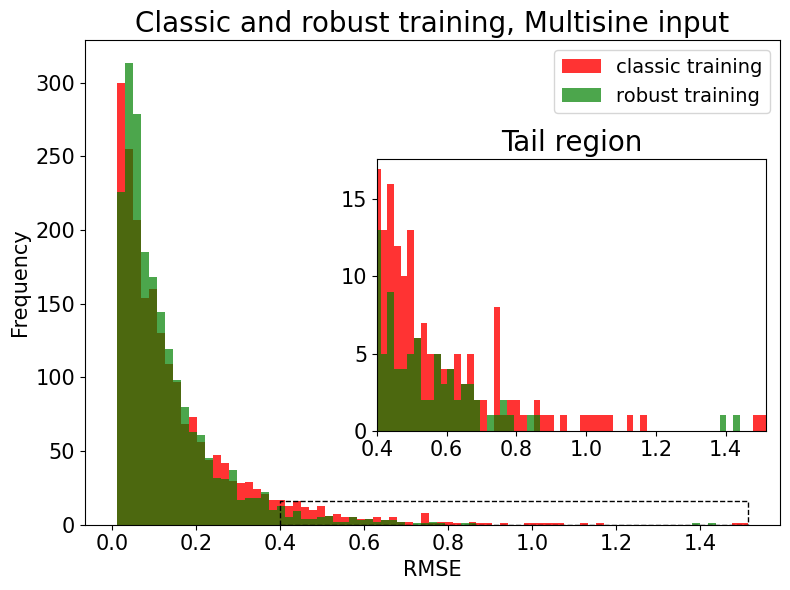

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
min_edge = min(rmse2.min(), rmse.min())
max_edge = rmse2.max()
bins = np.linspace(min_edge, max_edge, 80)

# Main plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')
ax.legend( fontsize = 14)
ax.set_title('Classic and robust training, Multisine input', fontsize = 20)
ax.set_xlabel('RMSE', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add an inset zoomed plot
inset_ax = inset_axes(ax, width="40%", height="40%", loc="lower center", bbox_to_anchor=(0, 0.18, 1.4, 1.4), 
                      bbox_transform=ax.transAxes)  # Adjust size and position
inset_ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
inset_ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')

# Zoom in on x > 0.2 for the inset
inset_ax.set_xlim(0.4, rmse2.max())
# Calculate the max y value in the zoomed-in area
hist_classic, _ = np.histogram(rmse2, bins=bins)
hist_robust, _ = np.histogram(rmse, bins=bins)
filtered_indices = bins[:-1] > 0.4
max_y_zoom = max(hist_classic[filtered_indices].max(), hist_robust[filtered_indices].max())
inset_ax.set_ylim(0, max_y_zoom + max_y_zoom * 0.1)

# Add labels to inset for clarity
inset_ax.set_title('Tail region', fontsize = 20)
inset_ax.tick_params(axis='both', labelsize=15)

# Optionally, draw a rectangle to indicate the zoomed region on the main plot
rect_x = [0.4, rmse2.max(), rmse2.max(), 0.4, 0.4]
rect_y = [0, 0, max_y_zoom, max_y_zoom, 0]
ax.plot(rect_x, rect_y, "k--", linewidth=1)

plt.tight_layout()
# plt.savefig('fig_robustL/Multisine_comparison.pdf')
plt.show()

In [17]:
_, indices_1 =torch.topk(torch.tensor(rmse),k = batch_size, largest = True)
_, indices_2 =torch.topk(torch.tensor(rmse2),k = batch_size, largest = True)

In [18]:
print(f"rmse over the tails robust and classic on whitenoise input 0.01 err{rmse[indices_1[:800]].mean(),rmse2[indices_2[:800]].mean()}, respectively")

rmse over the tails robust and classic on whitenoise input 0.01 err(0.24070455, 0.29218766), respectively


In [19]:
rmse_1 = rmse[rmse >= 0.5]
rmse2_1 = rmse2[rmse2 >= 0.5]

Text(0.5, 1.0, 'Comparison between tails classic and robust training multisine')

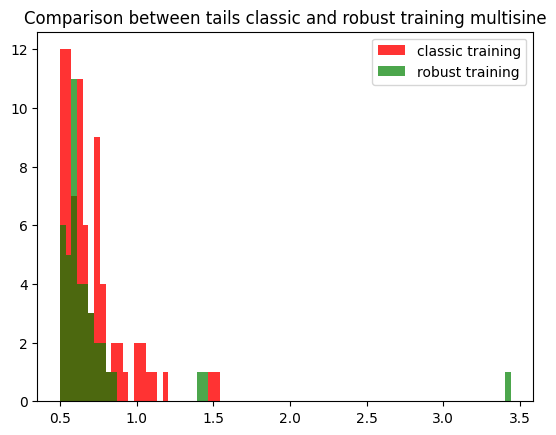

In [20]:
min_edge = min(rmse2_1.min(), rmse_1.min())
max_edge = max(rmse2_1.max(), rmse_1.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between tails classic and robust training multisine')

# WHITE NOISE ERR 0.01

In [19]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=1)
print(f"rmse robust and classic on whitenoise input 0.01 err {rmse.mean(),rmse2.mean()}, respectively")

rmse robust and classic on whitenoise input 0.01 err (0.07060498, 0.087835744), respectively


/tmp/ipykernel_1149727/3625937805.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


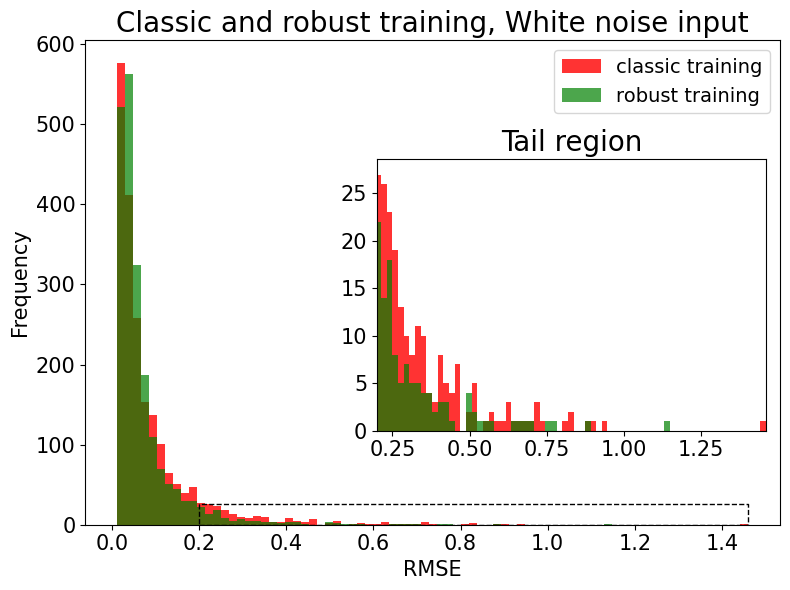

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
min_edge = min(rmse2.min(), rmse.min())
max_edge = rmse2.max()
bins = np.linspace(min_edge, max_edge, 80)

# Main plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')
ax.legend( fontsize = 14)
ax.set_title('Classic and robust training, White noise input', fontsize = 20)
ax.set_xlabel('RMSE', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add an inset zoomed plot
inset_ax = inset_axes(ax, width="40%", height="40%", loc="lower center", bbox_to_anchor=(0, 0.18, 1.4, 1.4), 
                      bbox_transform=ax.transAxes)  # Adjust size and position
inset_ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
inset_ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')

# Zoom in on x > 0.2 for the inset
inset_ax.set_xlim(0.2, rmse2.max())
# Calculate the max y value in the zoomed-in area
hist_classic, _ = np.histogram(rmse2, bins=bins)
hist_robust, _ = np.histogram(rmse, bins=bins)
filtered_indices = bins[:-1] > 0.2
max_y_zoom = max(hist_classic[filtered_indices].max(), hist_robust[filtered_indices].max())
inset_ax.set_ylim(0, max_y_zoom + max_y_zoom * 0.1)

# Add labels to inset for clarity
inset_ax.set_title('Tail region', fontsize = 20)
inset_ax.tick_params(axis='both', labelsize=15)

# Optionally, draw a rectangle to indicate the zoomed region on the main plot
rect_x = [0.2, rmse2.max(), rmse2.max(), 0.2, 0.2]
rect_y = [0, 0, max_y_zoom, max_y_zoom, 0]
ax.plot(rect_x, rect_y, "k--", linewidth=1)

plt.tight_layout()
# plt.savefig('fig_robustL/WN_comparison.pdf')
plt.show()

In [24]:
_, indices_1 =torch.topk(torch.tensor(rmse),k = batch_size, largest = True)
_, indices_2 =torch.topk(torch.tensor(rmse2),k = batch_size, largest = True)

In [25]:
rmse_1 = rmse[rmse >= 0.2]
rmse2_1 = rmse2[rmse2 >= 0.2]


In [28]:
print(f"rmse over the tails robust and classic on whitenoise input 0.01 err{rmse[indices_1[:800]].mean(),rmse2[indices_2[:800]].mean()}, respectively")

rmse over the tails robust and classic on whitenoise input 0.01 err(0.12899745, 0.17233822), respectively


Text(0.5, 1.0, 'Comparison between classic and robust training white noise')

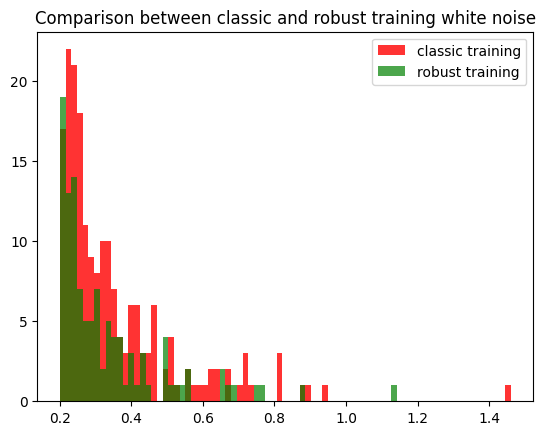

In [29]:
min_edge = min(rmse2_1.min(), rmse_1.min())
max_edge = max(rmse2_1.max(), rmse_1.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between classic and robust training white noise')

# RBS ERR 0.01

In [14]:
skip = 0
rmse = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean[:,:,0], time_axis=1)
rmse2 = metrics.rmse_test(batch_y_new[:, cfg.seq_len_n_in:, 0], batch_y_mean2[:,:,0], time_axis=1)
print(f"rmse robust and classic on RBS input 0.01 err {rmse.mean(),rmse2.mean()}, respectively")

rmse robust and classic on RBS input 0.01 err (0.22278416, 0.23164846), respectively


/tmp/ipykernel_1150600/3690145012.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


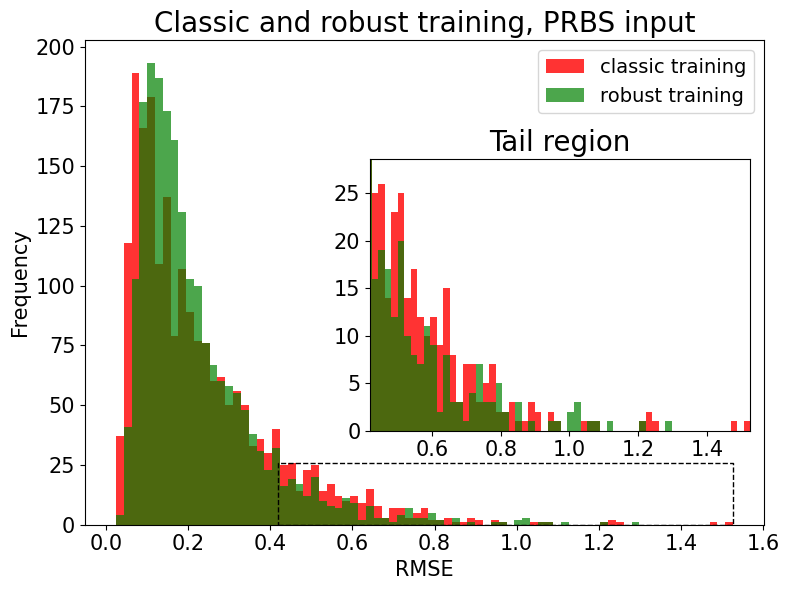

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
min_edge = min(rmse2.min(), rmse.min())
max_edge = rmse2.max()
bins = np.linspace(min_edge, max_edge, 80)

# Main plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')
ax.legend( fontsize = 14)
ax.set_title('Classic and robust training, PRBS input', fontsize = 20)
ax.set_xlabel('RMSE', fontsize = 15)
ax.set_ylabel('Frequency', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add an inset zoomed plot
inset_ax = inset_axes(ax, width="40%", height="40%", loc="lower center", bbox_to_anchor=(0, 0.18, 1.4, 1.4), 
                      bbox_transform=ax.transAxes)  # Adjust size and position
inset_ax.hist(rmse2, bins=bins, label='classic training', alpha=0.8, color='r')
inset_ax.hist(rmse, bins=bins, label='robust training', alpha=0.7, color='g')

# Zoom in on x > 0.2 for the inset
inset_ax.set_xlim(0.42, rmse2.max())
# Calculate the max y value in the zoomed-in area
hist_classic, _ = np.histogram(rmse2, bins=bins)
hist_robust, _ = np.histogram(rmse, bins=bins)
filtered_indices = bins[:-1] > 0.42
max_y_zoom = max(hist_classic[filtered_indices].max(), hist_robust[filtered_indices].max())
inset_ax.set_ylim(0, max_y_zoom + max_y_zoom * 0.1)

# Add labels to inset for clarity
inset_ax.set_title('Tail region', fontsize = 20)
inset_ax.tick_params(axis='both', labelsize=15)

# Optionally, draw a rectangle to indicate the zoomed region on the main plot
rect_x = [0.42, rmse2.max(), rmse2.max(), 0.42, 0.42]
rect_y = [0, 0, max_y_zoom, max_y_zoom, 0]
ax.plot(rect_x, rect_y, "k--", linewidth=1)

plt.tight_layout()
# plt.savefig('fig_robustL/PRBS_comparison.pdf')
plt.show()

In [41]:
_, indices_1 =torch.topk(torch.tensor(rmse),k = batch_size, largest = True)
_, indices_2 =torch.topk(torch.tensor(rmse2),k = batch_size, largest = True)

In [42]:
rmse_1 = rmse[rmse >= 0.5]
rmse2_1 = rmse2[rmse2 >= 0.5]

In [43]:
print(f"rmse over the tails robust and classic on rbs input 0.01 err {rmse[indices_1[:800]].mean(),rmse2[indices_2[:800]].mean()}, respectively")

rmse over the tails robust and classic on rbs input 0.01 err (0.36461562, 0.40467262), respectively


Text(0.5, 1.0, 'Comparison between classic and robust training white noise')

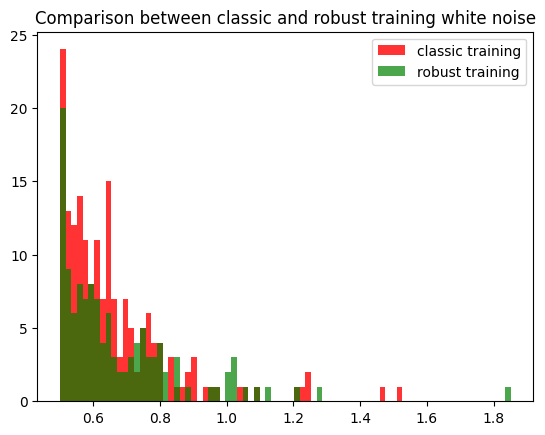

In [44]:
min_edge = min(rmse2_1.min(), rmse_1.min())
max_edge = max(rmse2_1.max(), rmse_1.max())
bins = np.linspace(min_edge, max_edge, 80)
plt.hist(rmse2_1, bins=bins, label = 'classic training', alpha = 0.8, color = 'r')
plt.hist(rmse_1,  bins=bins,label = 'robust training', alpha = 0.7, color = 'g')

plt.legend()
plt.title('Comparison between classic and robust training white noise')